In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-12-13 22:08:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-12-13 22:08:56 (5.56 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [5]:
!head /tmp/daily-min-temperatures.csv

"Date","Temp"
"1981-01-01",20.7
"1981-01-02",17.9
"1981-01-03",18.8
"1981-01-04",14.6
"1981-01-05",15.8
"1981-01-06",15.8
"1981-01-07",15.8
"1981-01-08",17.4
"1981-01-09",21.8


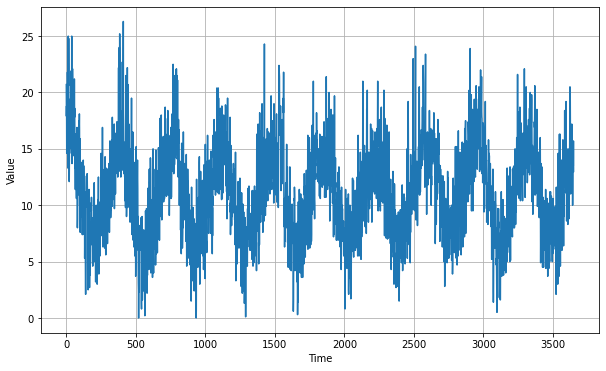

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  header = next(reader)
  for idx, row in enumerate(reader):
    time_step.append(idx)
    temps.append(float(row[1]))


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = np.array(time[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Add one dimension so you can use the tf window option
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  
  # Create a sliding window shifting one element per iteration
  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window 
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)

  # Combine all elements of a window again to one "datapoint"
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))

  # Get random datapoints per epoch
  ds = ds.shuffle(shuffle_buffer)

  # Split away the last element as the label/prediction/y
  ds = ds.map(lambda w: (w[:-1], w[1:]))

  # No clue why to do prefetch? Maybe use the CPU while the
  # GPU is training?
  return ds.batch(batch_size).prefetch(1)


In [46]:
def model_forecast(model, series, window_size):
  # Add one dimension so you can use the tf window option
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  
  # Create a sliding window shifting one element per iteration
  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window 
  ds = ds.window(window_size, shift=1, drop_remainder=True)

  # Combine all elements of a window again to one "datapoint"
  ds = ds.flat_map(lambda w: w.batch(window_size))

  # This needs to be batched, if not, during calling
  # the forecast, there are far to many results. Why???
  # Without the batch stament, ther result is [N, 1, 1]
  # With batching its [X, window_size, 1]
  ds = ds.batch(32).prefetch(1)

  return model.predict(ds)

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, padding='causal', input_shape=[None, 1], activation='relu'),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], batch_size=128)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 52ms/step - loss: 40.9903 - mae: 41.4903 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 66ms/step - loss: 40.3496 - mae: 40.8496 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 61ms/step - loss: 39.3670 - mae: 39.8670 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 62ms/step - loss: 38.1684 - mae: 38.6684 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 64ms/step - loss: 36.7866 - mae: 37.2866 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 64ms/step - loss: 35.2164 - mae: 35.7163 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 66ms/step - loss: 33.4457 - mae: 33.9456 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 62ms/step - loss: 31.4499 - mae: 31.9499 - l

(1e-08, 0.0001, 0.0, 60.0)

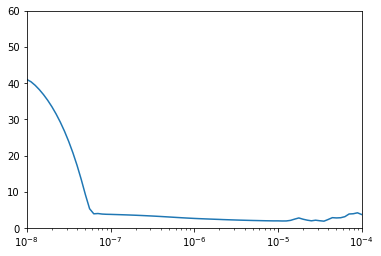

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(60, kernel_size=5, strides=1, padding='causal', input_shape=[None, 1], activation='relu'),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400.0) 
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 6s 41ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/50
25/25 [==============================] - 1s 40ms/step - loss: 2.5295 - mae: 2.9922
Epoch 3/50
25/25 [==============================] - 1s 40ms/step - loss: 1.9502 - mae: 2.4047
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/50
25/25 [==============================] - 1s 38ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/50
25/25 [==============================] - 1s 40ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/50
25/25 [==============================] - 1s 39ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/50
25/25 [==============================] - 1s 39ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/50
25/25 [==============================] - 1s 40ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/50
25/25 [==============================] - 1s 40

In [47]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [48]:
rnn_forecast.shape

(3587, 64, 1)

In [49]:
64*3587

229568

In [42]:
a = rnn_forecast[split_time - window_size:-1, -1, 0]

In [43]:
a.shape

(227131,)

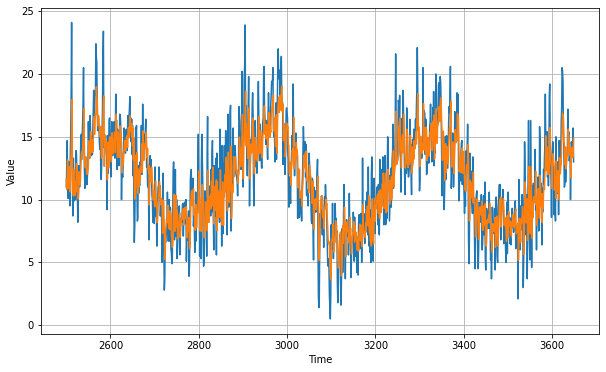

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7893442

In [29]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.595442 10.802751 11.799312 ... 13.357523 13.53594  14.889494]
